# Getting the data from Modo Energy API

In [6]:
import requests

url = "https://api.modoenergy.com/pub/v1/gb/elexon/bmrs/system/demand?date_from=2022-01-01&date_to=2024-03-03&limit=10000&offset=0"

headers = {
    "accept": "application/json",
    "X-Token": "293c4daa733e63b7737433232fbeb8855c341e92ce60b0c8382019f86b38###"
}

response = requests.get(url, headers=headers)

print(response.text)

{"count":38071,"next":"https://api.modoenergy.com/pub/v1/gb/elexon/bmrs/system/demand?date_from=2022-01-01&date_to=2024-03-03&limit=10000&offset=10000","previous":null,"results":[{"timestamp":"2024-03-03T23:30:00","period":48,"fact":27149.0,"forecast":27468.0},{"timestamp":"2024-03-03T23:00:00","period":47,"fact":27443.0,"forecast":27906.0},{"timestamp":"2024-03-03T22:30:00","period":46,"fact":28809.0,"forecast":29392.0},{"timestamp":"2024-03-03T22:00:00","period":45,"fact":30561.0,"forecast":31051.0},{"timestamp":"2024-03-03T21:30:00","period":44,"fact":32326.0,"forecast":32706.0},{"timestamp":"2024-03-03T21:00:00","period":43,"fact":33722.0,"forecast":34068.0},{"timestamp":"2024-03-03T20:30:00","period":42,"fact":35320.0,"forecast":34960.0},{"timestamp":"2024-03-03T20:00:00","period":41,"fact":36491.0,"forecast":36167.0},{"timestamp":"2024-03-03T19:30:00","period":40,"fact":37826.0,"forecast":37467.0},{"timestamp":"2024-03-03T19:00:00","period":39,"fact":38869.0,"forecast":38456.0},{

# Formatting 

In [7]:
data = response.json()

In [8]:
type(data)

dict

In [9]:
import pandas as pd
import json

In [10]:
# Extract the 'results' part of the dictionary
results = data['results']

# Convert the 'results' to DataFrame
df = pd.DataFrame(results)

In [11]:
df

,timestamp,period,fact,forecast
0,2024-03-03T23:30:00,48,27149.0,27468.0
1,2024-03-03T23:00:00,47,27443.0,27906.0
2,2024-03-03T22:30:00,46,28809.0,29392.0
3,2024-03-03T22:00:00,45,30561.0,31051.0
4,2024-03-03T21:30:00,44,32326.0,32706.0
...,...,...,...,...
9995,2023-08-08T18:00:00,39,29201.0,28800.0
9996,2023-08-08T17:30:00,38,29353.0,28876.0
9997,2023-08-08T17:00:00,37,29134.0,28880.0
9998,2023-08-08T16:30:00,36,29176.0,28785.0


In [12]:
df = df.set_index('timestamp')

In [13]:
result_data = df['forecast']

In [14]:
result_data

timestamp
2024-03-03T23:30:00    27468.0
2024-03-03T23:00:00    27906.0
2024-03-03T22:30:00    29392.0
2024-03-03T22:00:00    31051.0
2024-03-03T21:30:00    32706.0
                        ...   
2023-08-08T18:00:00    28800.0
2023-08-08T17:30:00    28876.0
2023-08-08T17:00:00    28880.0
2023-08-08T16:30:00    28785.0
2023-08-08T16:00:00    28348.0
Name: forecast, Length: 10000, dtype: float64

In [15]:
df = df.drop(['forecast', 'period'], axis=1)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

<AxesSubplot:xlabel='timestamp'>

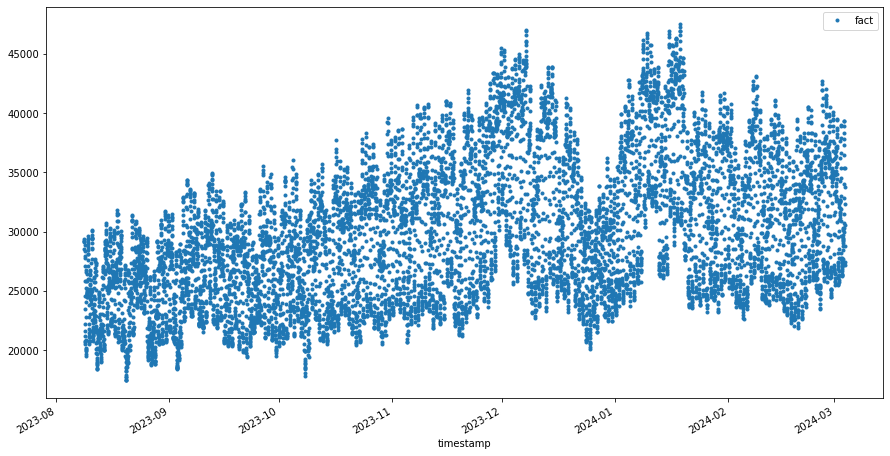

In [17]:
df.index = pd.to_datetime(df.index)

df.plot(style='.', figsize=(15,8))

In [18]:
df.index

DatetimeIndex(['2024-03-03 23:30:00', '2024-03-03 23:00:00',
               '2024-03-03 22:30:00', '2024-03-03 22:00:00',
               '2024-03-03 21:30:00', '2024-03-03 21:00:00',
               '2024-03-03 20:30:00', '2024-03-03 20:00:00',
               '2024-03-03 19:30:00', '2024-03-03 19:00:00',
               ...
               '2023-08-08 20:30:00', '2023-08-08 20:00:00',
               '2023-08-08 19:30:00', '2023-08-08 19:00:00',
               '2023-08-08 18:30:00', '2023-08-08 18:00:00',
               '2023-08-08 17:30:00', '2023-08-08 17:00:00',
               '2023-08-08 16:30:00', '2023-08-08 16:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=10000, freq=None)

# Train / Test

In [19]:
train = df.loc[df.index < '2024-02-01 00:00:00']
test = df.loc[df.index >='2024-02-01 00:00:00']

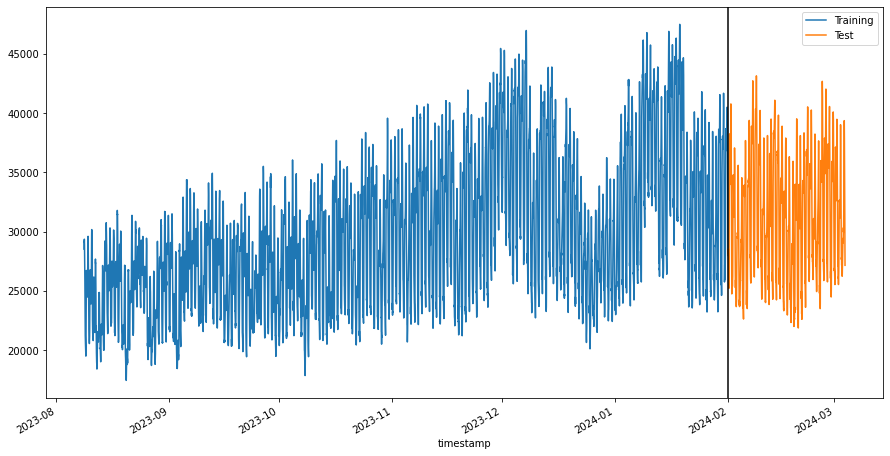

In [20]:
fig, ax = plt.subplots(figsize=(15,8))
train.plot(ax=ax, label='Training')
test.plot(ax=ax, label='Test')
ax.legend(['Training', 'Test'])
ax.axvline('2024-02-01 00:00:00', color = 'black')
plt.show()

<AxesSubplot:xlabel='timestamp'>

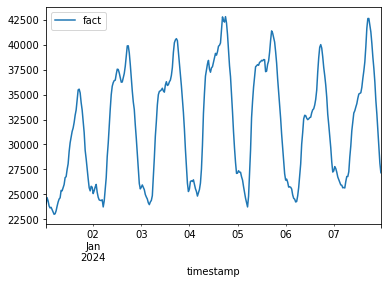

In [21]:
# One week of data
df.loc[(df.index > '2024-01-01 00:00:00') & (df.index < '2024-01-08 00:00:00')].plot()

<AxesSubplot:xlabel='timestamp'>

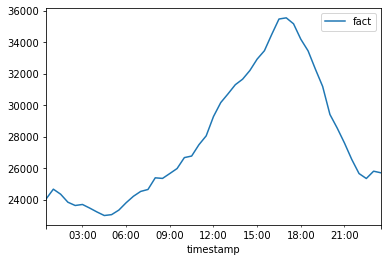

In [22]:
# One day of data
df.loc[(df.index > '2024-01-01 00:00:00') & (df.index < '2024-01-01 23:59:59')].plot()

In [23]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour + df.index.minute / 60.0
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [24]:
df.head()

,fact,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
timestamp,,,,,,,,,
2024-03-03 23:30:00,27149.0,23.5,6,1,3,2024,63,3,9
2024-03-03 23:00:00,27443.0,23.0,6,1,3,2024,63,3,9
2024-03-03 22:30:00,28809.0,22.5,6,1,3,2024,63,3,9
2024-03-03 22:00:00,30561.0,22.0,6,1,3,2024,63,3,9
2024-03-03 21:30:00,32326.0,21.5,6,1,3,2024,63,3,9


<AxesSubplot:xlabel='hour', ylabel='fact'>

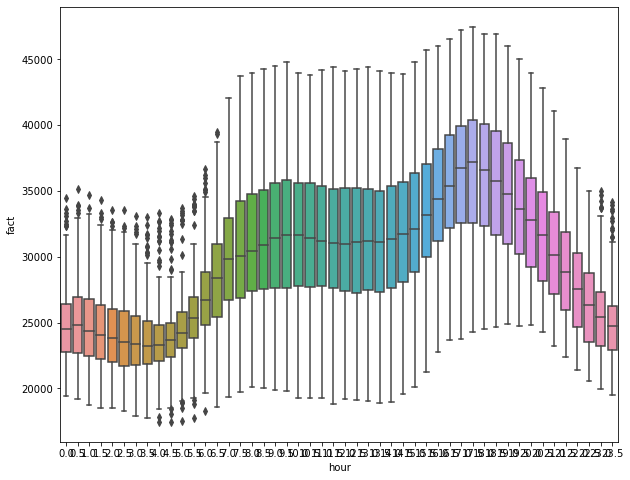

In [25]:
# See dailt trends
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='fact')

# Model

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
df

,fact,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
timestamp,,,,,,,,,
2024-03-03 23:30:00,27149.0,23.5,6,1,3,2024,63,3,9
2024-03-03 23:00:00,27443.0,23.0,6,1,3,2024,63,3,9
2024-03-03 22:30:00,28809.0,22.5,6,1,3,2024,63,3,9
2024-03-03 22:00:00,30561.0,22.0,6,1,3,2024,63,3,9
2024-03-03 21:30:00,32326.0,21.5,6,1,3,2024,63,3,9
...,...,...,...,...,...,...,...,...,...
2023-08-08 18:00:00,29201.0,18.0,1,3,8,2023,220,8,32
2023-08-08 17:30:00,29353.0,17.5,1,3,8,2023,220,8,32
2023-08-08 17:00:00,29134.0,17.0,1,3,8,2023,220,8,32


In [28]:
train = create_features(train)
test = create_features(test)

In [29]:
# Define the features and target variable
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'fact'

In [30]:
x_train = train[FEATURES]
y_train = train[TARGET]
x_test = test[FEATURES]
y_test = test[TARGET]

In [31]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.02)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:29548.05168	validation_1-rmse:31040.78813


C:\Users\Will Stevens\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [12:30:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:4945.12530	validation_1-rmse:4771.69136
[200]	validation_0-rmse:2173.46260	validation_1-rmse:2145.61236
[300]	validation_0-rmse:1767.64155	validation_1-rmse:1981.64956
[400]	validation_0-rmse:1622.41660	validation_1-rmse:1946.80612
[500]	validation_0-rmse:1536.02811	validation_1-rmse:1926.61658
[565]	validation_0-rmse:1497.81580	validation_1-rmse:1929.58342


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [32]:
pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importances'])

# As expected really

,importances
dayofyear,0.311980
hour,0.467743
dayofweek,0.220277
quarter,0.000000
month,0.000000
year,0.000000


In [33]:
df

,fact,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
timestamp,,,,,,,,,
2024-03-03 23:30:00,27149.0,23.5,6,1,3,2024,63,3,9
2024-03-03 23:00:00,27443.0,23.0,6,1,3,2024,63,3,9
2024-03-03 22:30:00,28809.0,22.5,6,1,3,2024,63,3,9
2024-03-03 22:00:00,30561.0,22.0,6,1,3,2024,63,3,9
2024-03-03 21:30:00,32326.0,21.5,6,1,3,2024,63,3,9
...,...,...,...,...,...,...,...,...,...
2023-08-08 18:00:00,29201.0,18.0,1,3,8,2023,220,8,32
2023-08-08 17:30:00,29353.0,17.5,1,3,8,2023,220,8,32
2023-08-08 17:00:00,29134.0,17.0,1,3,8,2023,220,8,32


In [34]:
test['prediction'] = reg.predict(x_test)

In [35]:
df = df.merge(test['prediction'], how='left', left_index=True, right_index=True)

In [36]:
df

,fact,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
timestamp,,,,,,,,,,
2023-08-08 16:00:00,28516.0,16.0,1,3,8,2023,220,8,32,NaN
2023-08-08 16:30:00,29176.0,16.5,1,3,8,2023,220,8,32,NaN
2023-08-08 17:00:00,29134.0,17.0,1,3,8,2023,220,8,32,NaN
2023-08-08 17:30:00,29353.0,17.5,1,3,8,2023,220,8,32,NaN
2023-08-08 18:00:00,29201.0,18.0,1,3,8,2023,220,8,32,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-03-03 21:30:00,32326.0,21.5,6,1,3,2024,63,3,9,28687.074219
2024-03-03 22:00:00,30561.0,22.0,6,1,3,2024,63,3,9,27302.220703
2024-03-03 22:30:00,28809.0,22.5,6,1,3,2024,63,3,9,25943.664062


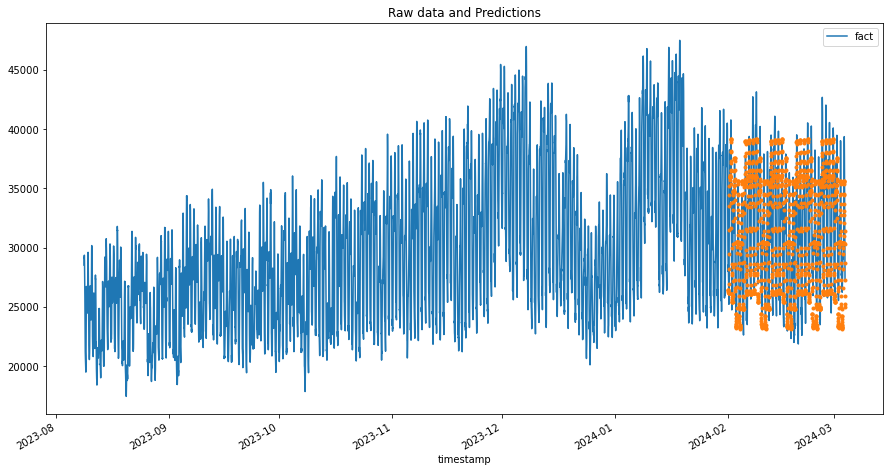

In [37]:
ax = df[['fact']].plot(figsize=(15,8))
df['prediction'].plot(ax=ax, style='.')
ax.set_title('Raw data and Predictions')
plt.show()

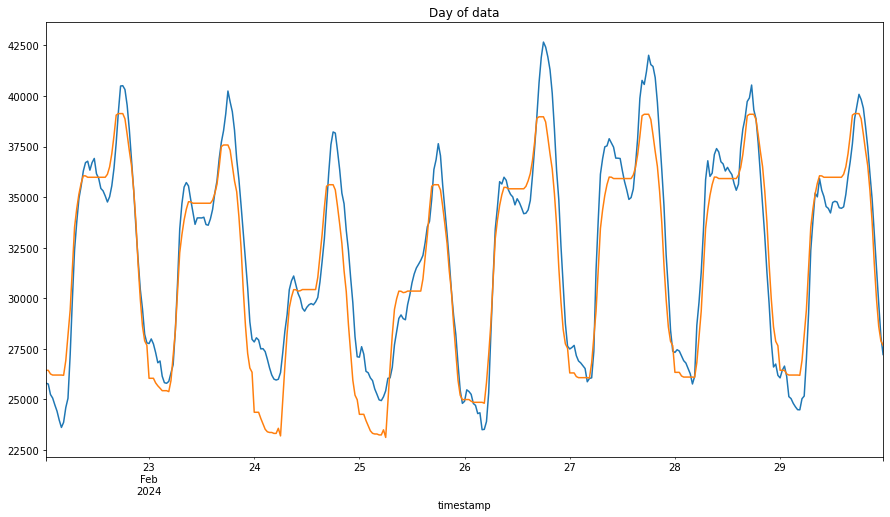

In [38]:
# 3 days day of data
ax = df.loc[(df.index > '2024-02-22 00:00:00') & (df.index < '2024-02-29 23:59:59')]['fact'].plot(figsize=(15,8), title='Day of data', kind='line')
df.loc[(df.index > '2024-02-22 00:00:00') & (df.index < '2024-02-29 23:59:59')]['prediction'].plot(ax=ax, kind='line')
plt.show()


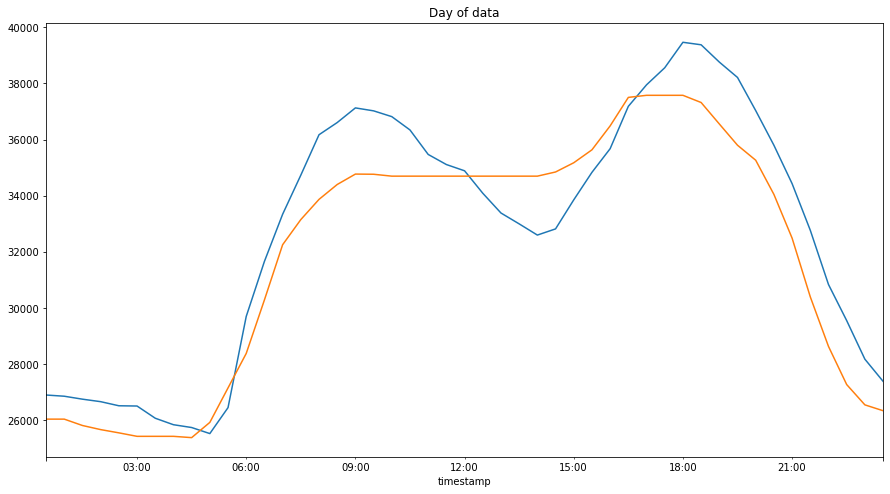

In [39]:
# One day of data
ax = df.loc[(df.index > '2024-03-01 00:00:00') & (df.index < '2024-03-01 23:59:59')]['fact'].plot(figsize=(15,8), title='Day of data', kind='line')
df.loc[(df.index > '2024-03-01 00:00:00') & (df.index < '2024-03-01 23:59:59')]['prediction'].plot(ax=ax, kind='line')
plt.show()


# Calculate Error

In [40]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [41]:
test['date'] = test.index.date

In [42]:
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

date
2024-02-20    2919.717204
2024-02-19    2435.006388
2024-02-05    2235.534058
2024-03-02    2201.655802
2024-03-03    2163.344971
Name: error, dtype: float64

# Accuracy

In [43]:
from sklearn.metrics import r2_score

In [44]:
y_pred = reg.predict(x_test)

# Calculating the R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

R^2 Score: 0.8548479579363577


# Add in extras

In [45]:
# Weather forecasts
# National holidays
# Sporting events